# Generating geomedian composites

These composites are for use in collecting training data.


### Load packages

In [1]:
%matplotlib inline

import numpy as np
import geopandas as gpd
import datacube
from odc.algo import to_f32, from_float, xr_geomedian
from datacube.utils import geometry
from datacube.helpers import write_geotiff
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../Scripts')
from deafrica_datahandling import load_ard
from deafrica_dask import create_local_dask_cluster
from deafrica_spatialtools import xr_rasterize
from deafrica_classificationtools import HiddenPrints

### Set up a dask cluster

In [2]:
create_local_dask_cluster(aws_unsigned=False)

Client Scheduler: tcp://127.0.0.1:46025 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


### Connect to the datacube

In [3]:
dc = datacube.Datacube(app='Geomedian_composites')

In [4]:
time_range = ('2018')

vector_file = 'data/tiles.shp'
attribute_col = 'id'
aez_region = 'data/AEZs/Southern.shp'

products = ['usgs_ls8c_level2_2']
measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2']
resolution = (-30, 30)
output_crs = 'EPSG:6933'
align = (15, 15)
dask_chunks= {'x':1500, 'y':1500, 'time':1}

export_prefix="data/training_validation/geomedians/Southern/Southern_geomedian_tile-"

In [5]:
# Create a reusable query
query = {'time': time_range,
         'measurements': measurements,
         'resolution': resolution,
         'output_crs': output_crs,
         'align': align,
         'dask_chunks':dask_chunks
         }

query

{'time': '2018',
 'measurements': ['red', 'green', 'blue', 'nir', 'swir1', 'swir2'],
 'resolution': (-30, 30),
 'output_crs': 'EPSG:6933',
 'align': (15, 15),
 'dask_chunks': {'x': 1500, 'y': 1500, 'time': 1}}

In [6]:
#read shapefile
gdf = gpd.read_file(vector_file)

# add an ID column
gdf[attribute_col]=range(0, len(gdf))

#print gdf
gdf.head()

,FID,geometry,id
0,0,"POLYGON ((-15.54625 28.13338, -15.54625 29.471...",0
1,1,"POLYGON ((-1.55463 29.47104, -1.55463 30.82621...",1
2,2,"POLYGON ((-3.10925 28.13338, -3.10925 29.47104...",2
3,3,"POLYGON ((-1.55463 28.13338, -1.55463 29.47104...",3
4,4,"POLYGON ((-3.10925 29.47104, -3.10925 30.82621...",4


Clip to region of interest

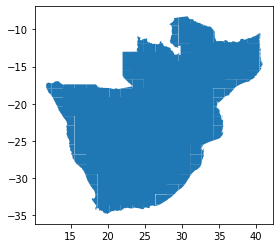

In [7]:
#open shapefile
aez=gpd.read_file(aez_region)
# clip points to region
gdf = gpd.overlay(gdf, aez, how='intersection')

gdf.plot()

In [8]:
%%time
# A progress indicator
i = 0

# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf[9:13].iterrows():
    
    print(" Feature {:02}/{:02}\r".format(i + 1, len(gdf)),
                  end='')
    
    # Get the geometry
    geom = geometry.Geometry(row.geometry.__geo_interface__,
                             geometry.CRS(f'EPSG:{gdf.crs.to_epsg()}'))
    
    # Update dc query with geometry      
    query.update({'geopolygon': geom}) 
    
    with HiddenPrints():
        ds = load_ard(dc=dc, 
                          products=products,                 
                          group_by='solar_day',
                          **query)
    
    # Generate a polygon mask to keep only data within the polygon
    with HiddenPrints():
        mask = xr_rasterize(gdf.iloc[[index]], ds)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    ds = ds.where(mask)
    
    sr_max_value = 65455                 # maximum value for SR in the loaded product
    scale, offset = (1/sr_max_value, 0)  # differs per product, aim for 0-1 values in float32

    #scale the values using the f_32 util function
    ds_scaled = to_f32(ds,
                       scale=scale,
                       offset=offset)
    #generate a geomedian
    geomedian = xr_geomedian(ds_scaled, 
                             num_threads=1,  
                             eps=1e-7,  
                             nocheck=True)
    
    geomedian = geomedian.compute()
    
    #convert SR scaling values back to original values
    geomedian = from_float(geomedian, 
                           dtype='float32', 
                           nodata=np.nan, 
                           scale=1/scale, 
                           offset=-offset/scale)
    
    write_geotiff(export_prefix+str(row[attribute_col]) + '.tif', 
                  geomedian)
    
    # Update counter
    i += 1
    

---
Code to get geojson from datacube UI 

In [ ]:
# from datacube import Datacube
# from odc.ui import DcViewer
# dc = Datacube()
# ui = DcViewer(dc, "2018", products=['ga_ls8c_gm_2_annual'])
# ui

# x = ui._gui.map.layers[1].data

# from shapely.geometry import shape
# geom = [shape(i) for i in x['features']]
# gdf = gpd.GeoDataFrame({'geometry':geom}, crs='EPSG:4326')
# gdf.to_file('data/tiles.shp')